Step 1: Load Libraries and Data

In [4]:
#Import packages
import numpy as np
import pandas as pd

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

In [5]:
# File paths
tsv_file = '.\\Participant_data/jakob8.tsv'
#log_file = '.\\Participant_data/subject-Claudius_log.txt'
#csv_file = '.\\Participant_data/subject-Claudius.csv'

# Load the data
data_tsv = pd.read_csv(tsv_file, sep='\t')
#data_csv = pd.read_csv(csv_file)

In [6]:

# #import CSV
# # loop to define,and append the variables into a list.
# df = []
# amt = 4 # The amount of properly labeled tsv files
# for n in range(amt):
#     #d = pd.read_csv(fr'.\\subject-{n+1}.tsv', sep='\t')
#     d = pd.read_csv(fr'.\\Participant_data/subject-Claudius.tsv', sep='\t')
#     #F-strings ('f' before the opening quotation mark) provide a way to embed variables and expressions directly within strings.  
#     df.append(d)
#     #If you want to call subject3 (df3), you can call df[3], if you want df5, call df[5], etc.
#     # Test whether data_tsv is a Pandas dataFrame
#     assert isinstance(df[n], pd.dataFrame) == True

In [7]:
# # Sample subject to visualize (you can change this)
# subject_index = 0  # For example 2, to visualize subject 3

# # Select the relevant data_tsvFrame
# data_tsv = df[subject_index]

In [27]:
#display 5 rows of 1st participant
data_tsv.head(5)
#TODO BPOGX raw data, FPOGX average (used for fixation of eyetracker)

,CNT,TIME,TIME_TICK,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPOGX,...,LPUPILV,REYEX,REYEY,REYEZ,RPUPILD,RPUPILV,CX,CY,CS,USER
0,24044,389.99109,86428102589,0.00000,0.00000,389.55438,0.25848,562,0,0.44081,...,1,0.03819,0.02135,0.57628,0.00527,1,-0.47656,0.52778,0,START_TRIAL
1,24045,390.00714,86428262893,0.00000,0.00000,389.55438,0.25848,562,0,0.44081,...,1,0.03819,0.02135,0.57628,0.00527,1,-0.47656,0.52778,0,NaN
2,24046,390.02353,86428426762,0.50845,0.34283,389.55438,0.25848,562,0,0.50078,...,1,0.03819,0.02135,0.57628,0.00527,1,-0.47656,0.52778,0,NaN
3,24047,390.03931,86428584772,0.51052,0.34350,389.55438,0.25848,562,0,0.51642,...,1,0.03819,0.02135,0.57628,0.00525,1,-0.47656,0.52778,0,NaN
4,24048,390.05557,86428747409,0.51120,0.34290,389.55438,0.25848,562,0,0.51642,...,1,0.03933,0.02200,0.59138,0.00526,1,-0.47656,0.52778,0,NaN


In [9]:
#data_csv.head(5)

Step 2: Load and Parse Log Data

In [10]:
# # Load log data
# with open(log_file, 'r') as file:
#     log_data = file.readlines()

# # Parse log data
# logs = []
# for line in log_data:
#     if "start_trial" in line or "stop_trial" in line or "coordinates" in line:
#         logs.append(line.strip())
        
# # Create DataFrame for logs
# log_df = pd.DataFrame(logs, columns=['log'])

# # Function to extract timestamps and other details from logs
# def extract_log_details(log_df):
#     events = []
#     for index, row in log_df.iterrows():
#         if "start_trial" in row['log']:
#             events.append({'timestamp': index, 'event': 'start_trial'})
#         elif "stop_trial" in row['log']:
#             events.append({'timestamp': index, 'event': 'stop_trial'})
#         elif "coordinates" in row['log']:
#             coords = row['log'].split(':')[1].strip()
#             events.append({'timestamp': index, 'event': 'coordinates', 'coords': coords})
#     return pd.DataFrame(events)

# # Extracting log details
# log_events = extract_log_details(log_df)
# log_events.head()

Step 3: Different Plots

Step 3.1: Distribution of FPOGX

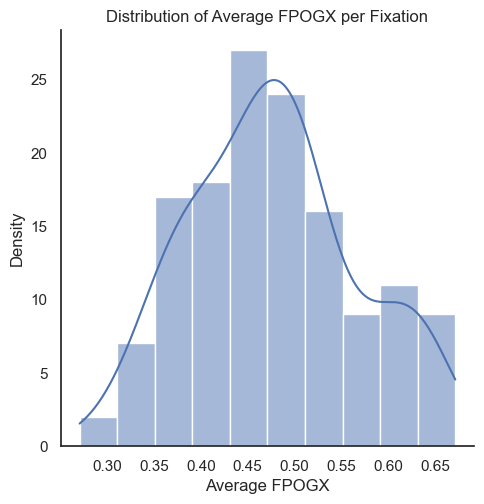

In [11]:
df_fixations = data_tsv.groupby('FPOGID')['FPOGX'].mean().reset_index()

# Plot the distribution using seaborn's displot
sns.displot(df_fixations, x='FPOGX', kde=True) 
plt.title('Distribution of Average FPOGX per Fixation')
plt.xlabel('Average FPOGX')
plt.ylabel('Density')
plt.show()

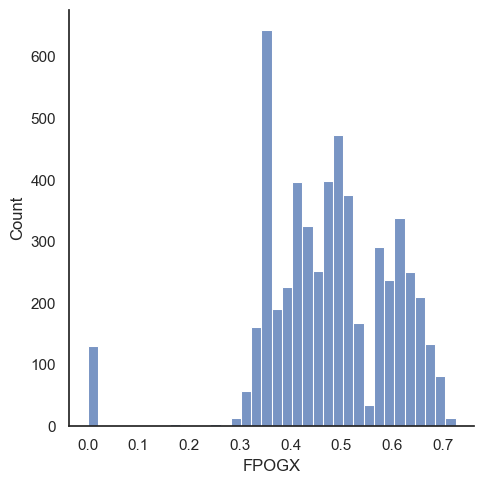

In [12]:
#test the dataset with a displot
#Use FPOGID instead of count to get Valid Counts (One fixation gets many counts)
sns.displot(data_tsv, x='FPOGX')

Step 3.2: Plot Time Against X-Position with Vertical Lines for Each User Log/Trigger

In [37]:
# Filter the data_tsv for different event types
fixation_points = data_tsv[data_tsv['USER'] == 'FIXATION_STIMULUS']
start_trial_points = data_tsv[data_tsv['USER'] == 'START_TRIAL']
stop_trial_points = data_tsv[data_tsv['USER'] == 'STOP_TRIAL']
stimuli_points = data_tsv[data_tsv['USER'] == 'STIMULI']
coordinates_points = data_tsv[data_tsv['USER'] == 'COORDINATES']

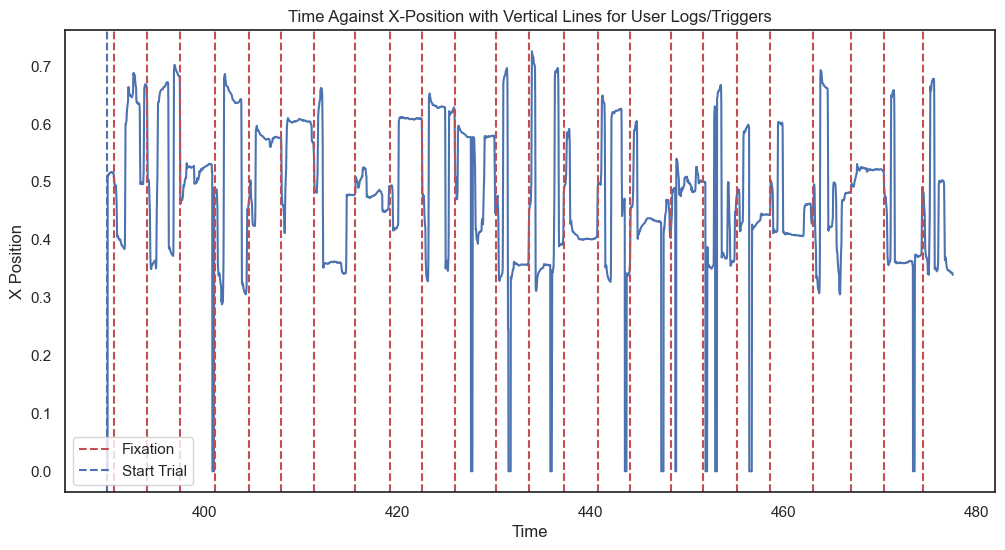

In [28]:

# **Time vs. X Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("X Position")
#plt.xlim(3500, 3600)

# Filter the data_tsv for different event types
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION_STIMULUS']['TIME']
start_trial_times = data_tsv[data_tsv['USER'] == 'START_TRIAL']['TIME']
stop_trial_times = data_tsv[data_tsv['USER'] == 'STOP_TRIAL']['TIME']
stimuli_times = data_tsv[data_tsv['USER'] == 'STIMULI']['TIME']
coordinates_times = data_tsv[data_tsv['USER'] == 'COORDINATES']['TIME']

# Add vertical lines for each event type
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--', label='Fixation' if fixation_time == fixation_times.iloc[0] else "")
for start_trial_time in start_trial_times:
    plt.axvline(x=start_trial_time, color='b', linestyle='--', label='Start Trial' if start_trial_time == start_trial_times.iloc[0] else "")
for stop_trial_time in stop_trial_times:
    plt.axvline(x=stop_trial_time, color='g', linestyle='--', label='Stop Trial' if stop_trial_time == stop_trial_times.iloc[0] else "")
for stimuli_time in stimuli_times:
    plt.axvline(x=stimuli_time, color='m', linestyle='--', label='Stimuli' if stimuli_time == stimuli_times.iloc[0] else "")
for coordinates_time in coordinates_times:
    plt.axvline(x=coordinates_time, color='y', linestyle='--', label='Coordinates' if coordinates_time == coordinates_times.iloc[0] else "")

# Add a legend
plt.legend()

plt.show()
#TODO: X und Y in einen Plot


In [15]:
# # **Time vs. X Plot**
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
# plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
# plt.xlabel("Time")
# plt.ylabel("X Position")

# # Add vertical lines for each user log/trigger
# for trigger_time in data_csv['time_image_stimulus']:
#  plt.axvline(x=trigger_time, color='r', linestyle='--')
# plt.show()

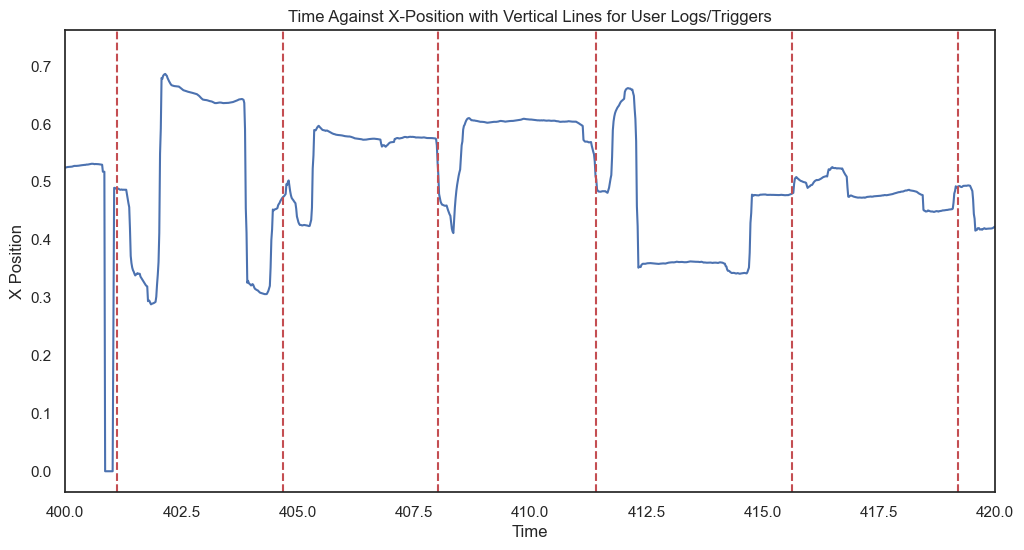

In [29]:
# **Time vs. X Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("X Position")
plt.xlim(400, 420)
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION_STIMULUS']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

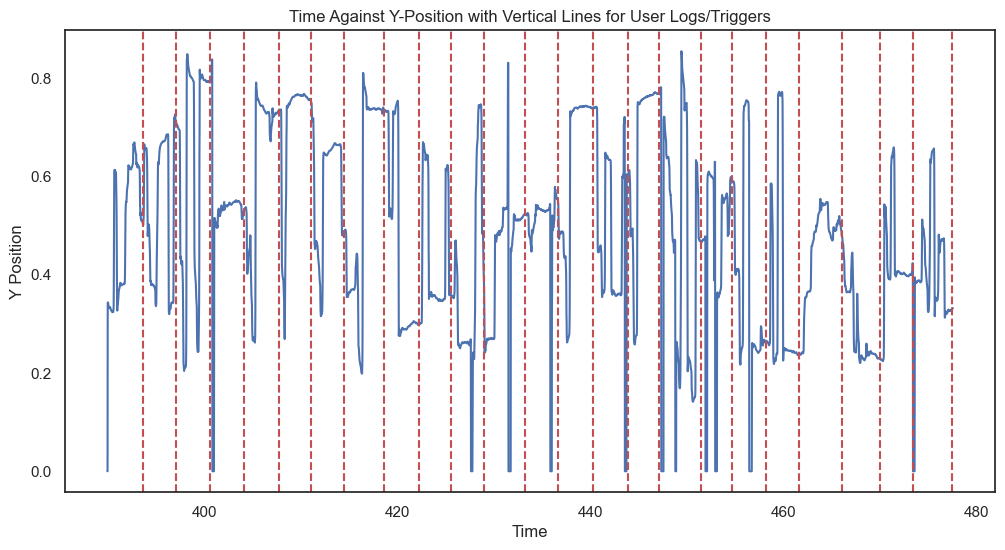

In [17]:
# **Time vs. Y Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
plt.title('Time Against Y-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("Y Position")
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

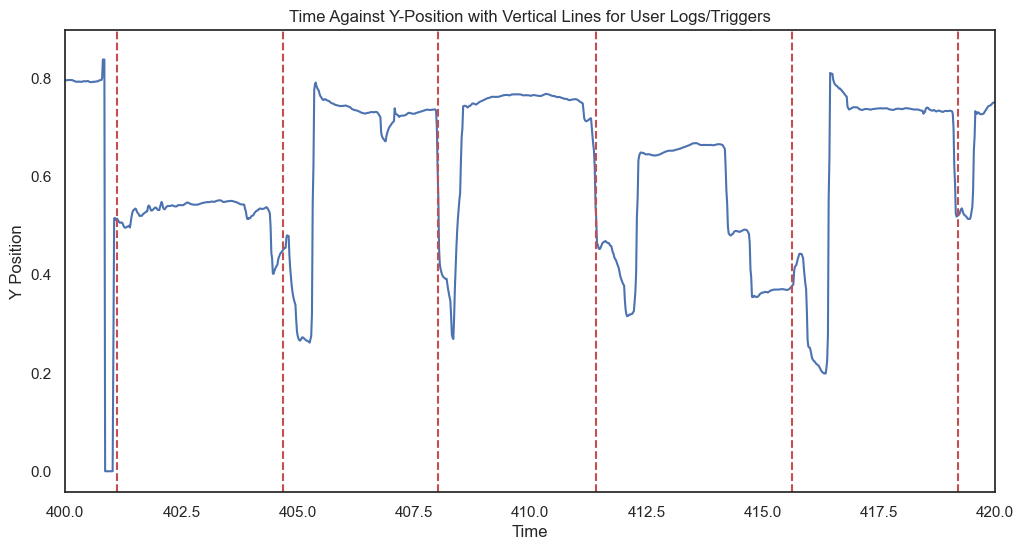

In [30]:
# **Time vs. Y Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
plt.title('Time Against Y-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("Y Position")
plt.xlim(400, 420)
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION_STIMULUS']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

In [19]:
# # **Time vs. Y Plot** zoom in
# sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
# # Zoom in on the x-axis between 0.6 and 0.7
# plt.xlim(3550, 3600)
# plt.title(f"Subject {subject_index + 1} - Y Position over Time")
# plt.xlabel("Time")
# plt.ylabel("Y Position")
# plt.show()

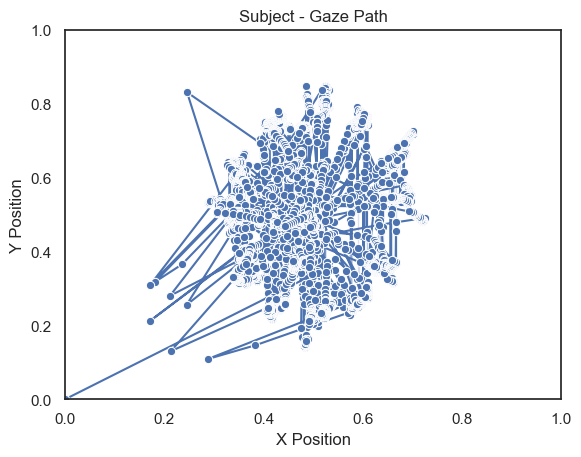

In [20]:
# **X vs. Y Plot (Gaze Path)**
#sns.scatterplot(data_tsv=data_tsv, x="FPOGX", y="FPOGY", s=40, hue='FPOGID')  # Use scatterplot for gaze path
sns.lineplot(data=data_tsv, x="FPOGX", y="FPOGY", marker='o', sort =False)  # Use scatterplot for gaze path
# Zoom in on the x-axis between 0.6 and 0.7

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


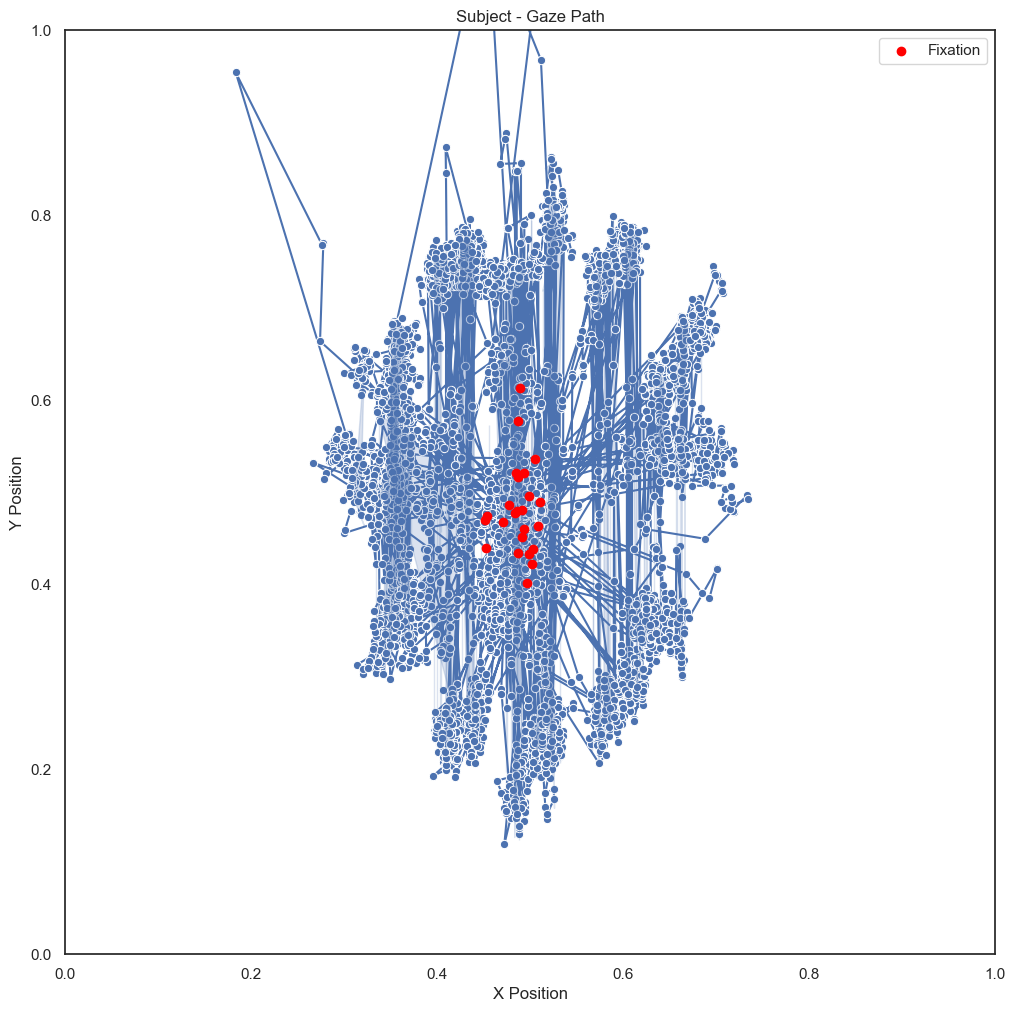

In [39]:


# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 12))
sns.lineplot(data=data_tsv, x="BPOGX", y="BPOGY", marker='o', sort=False, zorder=1)

# Add scatter plots for different event types
plt.scatter(fixation_points["BPOGX"], fixation_points["BPOGY"], color='red', label='Fixation', zorder=2)
# plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
# plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
# plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Stimuli', zorder=8)
# plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()


In [41]:

# Function to get time frames for FIXATION_STIMULUS
def get_fixation_stimulus_time_frames(data):

    if fixation_points.empty:
        return []
    time_frames = []
    fixation_points = fixation_points.sort_values(by='TIME')
    current_start = fixation_points['TIME'].iloc[0]
    current_end = current_start
    
    for time in fixation_points['TIME'].iloc[1:]:
        if time - current_end > 1:  # Assuming a gap larger than 1 second indicates a new stimulus
            time_frames.append((current_start, current_end))
            current_start = time
        current_end = time
    
    time_frames.append((current_start, current_end))
    return time_frames

# Get time frames for FIXATION_STIMULUS
time_frames = get_fixation_stimulus_time_frames(data_tsv)

# Plot data for each time frame
for start_time, end_time in time_frames:
    filtered_data = data_tsv[(data_tsv['TIME'] >= start_time) & (data_tsv['TIME'] <= end_time)]
    
    fixation_points = filtered_data[filtered_data['USER'] == 'FIXATION']
    start_trial_points = filtered_data[filtered_data['USER'] == 'START_TRIAL']
    stop_trial_points = filtered_data[filtered_data['USER'] == 'STOP_TRIAL']
    stimuli_points = filtered_data[filtered_data['USER'] == 'STIMULI']
    coordinates_points = filtered_data[filtered_data['USER'] == 'COORDINATES']

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", marker='o', sort=False)

    # Add scatter plots for different event types
    plt.scatter(fixation_points["FPOGX"], fixation_points["FPOGY"], color='red', label='Fixation', zorder=5)
    plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
    plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
    plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Stimuli', zorder=8)
    plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

    plt.title(f"Subject Gaze Path from {start_time} to {end_time}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()


UnboundLocalError: cannot access local variable 'fixation_points' where it is not associated with a value

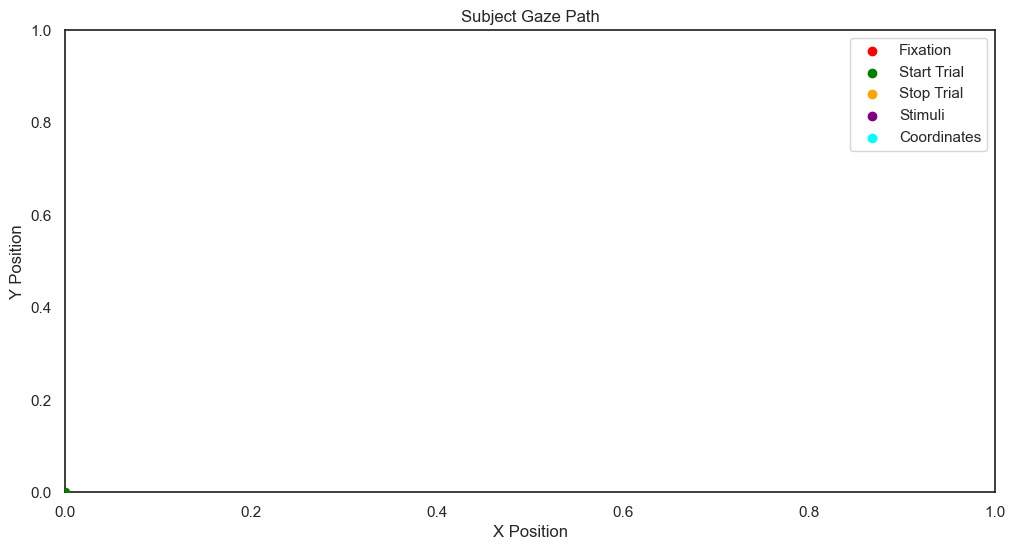

In [22]:
# Filter the data_tsv for the specified time range
filtered_data = data_tsv[(data_tsv['TIME'] >= 3550) & (data_tsv['TIME'] <= 3600)]

# Filter the data_tsv for fixation points within the specified time range
fixation_points = filtered_data[filtered_data['USER'] == 'FIXATION']

# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", marker='o', sort=False)

# Add scatter plots for different event types
plt.scatter(fixation_points["FPOGX"], fixation_points["FPOGY"], color='red', label='Fixation', zorder=5)
plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Stimuli', zorder=8)
plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

plt.title(f"Subject Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()
#TODO Heat map 
# also put the pics in the background

Step 4: Check for Balancing/Randomization Errors

In [23]:
def check_balancing_errors(data_tsv):
    # Count the occurrences of each unique value in the 'USER' column
    
    event_counts = data_tsv['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    
    print()  # Add a blank line for better readability

check_balancing_errors(data_tsv)
#TODO check the dtected expected values. 
# If they do not match check if they are overwriten (too short amount of time to write)

Event frequency in the 'USER' column:
USER
FIXATION_STIMULUS    24
FIXATION             24
START_TRIAL           1
Name: count, dtype: int64



Step 5: Calculate Accuracy/Precision while Gaze is on a Fixation-Cross

In [24]:
def calculate_accuracy_precision(data_tsv):
    fixation_cross_coords = (0, 0)  # Assuming fixation cross is at the center
    
    # Filter data for fixation events of USER column with FIXATION value
    fixation_data = data_tsv[(data_tsv['USER'] == 'FIXATION')]
    
    # Calculate distances from fixation cross
    fixation_distances = np.sqrt((fixation_data['FPOGX'] - fixation_cross_coords[0])**2 + 
                                 (fixation_data['FPOGY'] - fixation_cross_coords[1])**2)
    
    accuracy = fixation_distances.mean()
    precision = fixation_distances.std()   
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")

calculate_accuracy_precision(data_tsv)


Accuracy: 0.6930706720131538
Precision: 0.21365275017162275
